Accuracy for Decision Tree: 0.8137
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      3069
           1       0.82      0.79      0.80      2814

    accuracy                           0.81      5883
   macro avg       0.81      0.81      0.81      5883
weighted avg       0.81      0.81      0.81      5883



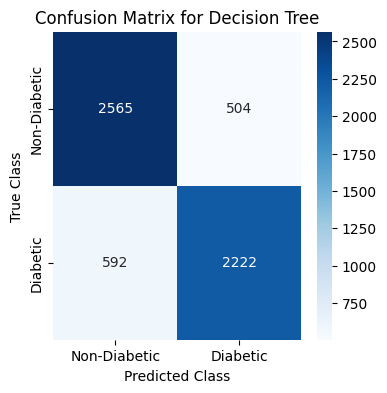

--------------------------------------------------------
Accuracy for Naive Bayes: 0.8042
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3069
           1       0.80      0.79      0.79      2814

    accuracy                           0.80      5883
   macro avg       0.80      0.80      0.80      5883
weighted avg       0.80      0.80      0.80      5883



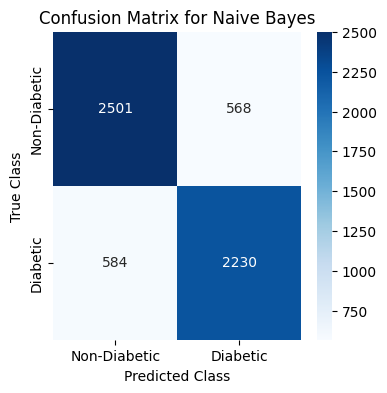

--------------------------------------------------------
Accuracy for Logistic Regression: 0.8144
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3069
           1       0.81      0.80      0.81      2814

    accuracy                           0.81      5883
   macro avg       0.81      0.81      0.81      5883
weighted avg       0.81      0.81      0.81      5883



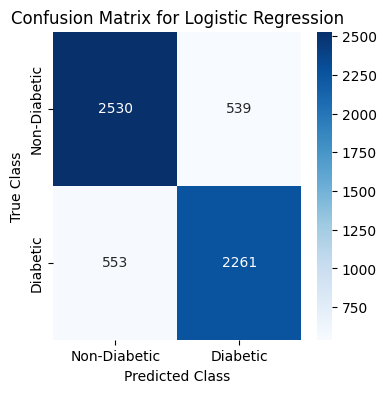

--------------------------------------------------------
Accuracy for KNN: 0.8246
              precision    recall  f1-score   support

           0       0.78      0.92      0.85      3069
           1       0.90      0.72      0.80      2814

    accuracy                           0.82      5883
   macro avg       0.84      0.82      0.82      5883
weighted avg       0.84      0.82      0.82      5883



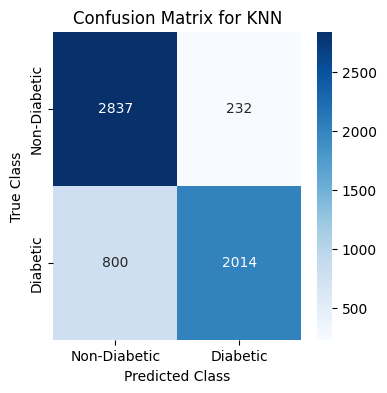

--------------------------------------------------------
Accuracy for KNN: 0.8419
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3069
           1       0.90      0.76      0.82      2814

    accuracy                           0.84      5883
   macro avg       0.85      0.84      0.84      5883
weighted avg       0.85      0.84      0.84      5883



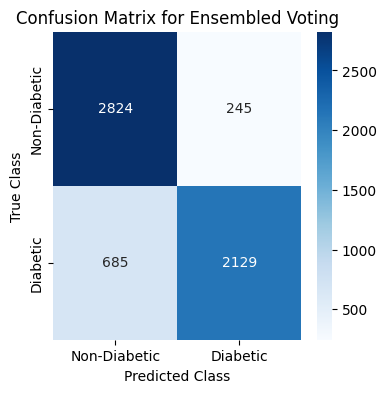

--------------------------------------------------------


In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from joblib import Parallel, delayed

## Naive Bayes
def train_naive_bayes(X_train, y_train):
    class_priors = pd.Series(y_train).value_counts(normalize=True).to_dict()

    cols = X_train.columns.tolist()
    naive_probs = {}
    for class_label, class_data in pd.concat([X_train, y_train], axis=1).groupby(
        y_train.name
    ):
        class_probs = {}
        for feature in cols:
            feature_probs = class_data[feature].value_counts(normalize=True).to_dict()
            class_probs[feature] = feature_probs
        naive_probs[class_label] = class_probs

    return class_priors, naive_probs


def naive_bayes_classifier(sample, class_priors, naive_probs):
    class_scores = {}
    for class_label, class_prob in class_priors.items():
        log_prob = np.log(class_prob)
        for feature, value in sample.items():
            if feature in naive_probs[class_label]:
                log_prob += np.log(naive_probs[class_label][feature].get(value, 1e-2))
        class_scores[class_label] = log_prob
    return max(class_scores, key=class_scores.get)


def predict_naive_bayes(X_train, y_train, X_valid):
    class_priors, naive_probs = train_naive_bayes(X_train, y_train)
    predictions = X_valid.apply(
        lambda x: naive_bayes_classifier(x, class_priors, naive_probs), axis=1
    )
    return predictions


## Decision tree
def myDT(Xtrain, Ytrain, Xvalid):
    class DecisionTree:
        def __init__(self):
            self.tree = None

        def fit(self, X, Y):
            self.tree = self._build_tree(X, Y)

        def predict(self, X):
            predictions = []
            for sample in X:
                predictions.append(self._predict_sample(sample, self.tree))
            return np.array(predictions)

        def _entropy(self, Y):
            classes, counts = np.unique(Y, return_counts=True)
            probabilities = counts / len(Y)
            entropy = -np.sum(probabilities * np.log2(probabilities))
            return entropy

        def _information_gain(self, X, Y, feature_index):
            unique_values = np.unique(X[:, feature_index])
            total_entropy = self._entropy(Y)

            weighted_entropy = 0
            for value in unique_values:
                subset_indices = X[:, feature_index] == value
                subset_Y = Y[subset_indices]
                weighted_entropy += len(subset_Y) / len(Y) * self._entropy(subset_Y)

            information_gain = total_entropy - weighted_entropy
            return information_gain

        def _build_tree(self, X, Y, depth=0):
            num_samples, num_features = X.shape
            unique_classes = np.unique(Y)

            # Base cases
            if len(unique_classes) == 1:
                # If all samples belong to the same class, return a leaf node
                return {"class": unique_classes[0]}
            # Limit the depth for simplicity
            if depth == 1000:
                # If maximum depth is reached, return a leaf node with the majority class
                majority_class = np.argmax(np.bincount(Y))
                return {"class": majority_class}

            # Find the best split
            best_feature = None
            best_information_gain = -1
            for feature_index in range(num_features):
                information_gain = self._information_gain(X, Y, feature_index)
                if information_gain > best_information_gain:
                    best_feature = feature_index
                    best_information_gain = information_gain

            if best_information_gain == 0:
                # If no information gain, return a leaf node with the majority class
                majority_class = np.argmax(np.bincount(Y))
                return {"class": majority_class}

            # Split the data based on the best feature
            unique_values = np.unique(X[:, best_feature])
            node = {"feature": best_feature, "children": {}}
            for value in unique_values:
                subset_indices = X[:, best_feature] == value
                subset_X = X[subset_indices]
                subset_Y = Y[subset_indices]
                node["children"][value] = self._build_tree(
                    subset_X, subset_Y, depth + 1
                )

            return node

        def _predict_sample(self, sample, tree):
            if "class" in tree:
                # If leaf node, return the class
                return tree["class"]
            else:
                # Recursively traverse the tree
                feature_value = sample[tree["feature"]]
                if feature_value not in tree["children"]:
                    # If the feature value is not in the training data, return majority class
                    return np.argmax(np.bincount(Y))
                else:
                    return self._predict_sample(sample, tree["children"][feature_value])

    dt = DecisionTree()
    dt.fit(Xtrain, Ytrain)
    predictions = dt.predict(Xvalid)
    return predictions


### Logistics regression

mean_log_loss_trn = []
mean_log_loss_val = []


class LogisticRegression:
    def __init__(self, learning_rate=0.01, num_iterations=10000, verbose=False):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.verbose = verbose
        self.weights = None
        self.bias = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, Y, x_val, y_val):
        global mean_log_loss_trn, mean_log_loss_val
        num_samples, num_features = X.shape

        # Initialize weights and bias
        self.weights = np.zeros(num_features)
        self.weights_val = np.zeros(x_val.shape[1])
        self.bias = 0
        self.bias_val = 0
        # Gradient descent
        for i in range(self.num_iterations):
            
            # Compute predicted values
            linear_model = np.dot(X, self.weights) + self.bias
            linear_model_x_val = np.dot(x_val, self.weights_val) + self.bias_val
            predictions_x_train = self.sigmoid(linear_model)
            predictions_x_val = self.sigmoid(linear_model_x_val)

            # Compute gradients
            dw_tn = (1 / num_samples) * np.dot(X.T, (predictions_x_train - Y))
            dw_val = (1 / num_samples) * np.dot(x_val.T, (predictions_x_val - y_val))

            db_tn = (1 / num_samples) * np.sum(predictions_x_train - Y)
            db_val = (1 / num_samples) * np.sum(predictions_x_val - y_val)

            # Update weights and bias
            self.weights_val -= self.learning_rate * dw_val
            self.bias_val -= self.learning_rate * db_val
            self.weights -= self.learning_rate * dw_tn
            self.bias -= self.learning_rate * db_tn
            mean_log_loss_val.append(
                (-1 / num_samples)
                * np.sum(
                    y_val * np.log(predictions_x_val)
                    + (1 - y_val) * np.log(1 - predictions_x_val)
                )
            )
            mean_log_loss_trn.append(
                (-1 / num_samples)
                * np.sum(
                    Y * np.log(predictions_x_train)
                    + (1 - Y) * np.log(1 - predictions_x_train)
                )
            )

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        predictions = self.sigmoid(linear_model)
        return np.round(predictions)


### KNN


def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((point1 - point2) ** 2))


def knn_predict(X_train, Y_train, X_valid, k=2, n_jobs=-1):
    predictions = []

    def process_row(valid_row, X_train, Y_train, k):
        distances = []
        for train_index, train_row in X_train.iterrows():
            dist = euclidean_distance(valid_row, train_row)
            distances.append((train_index, dist))

        distances.sort(key=lambda x: x[1])
        neighbors = distances[:k]
        neighbor_labels = [Y_train.loc[i[0]] for i in neighbors]

        # Perform a simple majority vote
        prediction = max(set(neighbor_labels), key=neighbor_labels.count)
        return prediction

    # Use joblib for parallel processing
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(process_row)(valid_row, X_train, Y_train, k)
        for _, valid_row in X_valid.iterrows()
    )

    return predictions


## evaluations
def evaluate_performance(Ytrue, Ypred):
    accuracy = (Ypred == Ytrue).mean()

    unique_classes = sorted(Ytrue.unique())
    conf_matrix = np.zeros((len(unique_classes), len(unique_classes)))

    for i, true_class in enumerate(unique_classes):
        for j, predicted_class in enumerate(unique_classes):
            conf_matrix[i, j] = np.sum(
                (Ytrue == true_class) & (Ypred == predicted_class)
            )

    return accuracy, conf_matrix


# Step 1: Reading in the data
df = pd.read_csv("diabetes_prediction_dataset.csv")
df = pd.get_dummies(df, columns=["gender", "smoking_history"])

# Selecting data for diabetic and non-diabetic patients
diabetic_data = df[df["diabetes"] == 1]
non_diabetic_data = df[df["diabetes"] == 0].sample(frac=0.1)
data = pd.concat([diabetic_data, non_diabetic_data])

# Step 2: Shuffling the observations
data = data.sample(frac=1, random_state=13).reset_index(drop=True)

# Columns to use for training and validation
cols = [
    "age",
    "hypertension",
    "heart_disease",
    "bmi",
    "HbA1c_level",
    "blood_glucose_level",
    "gender_Female",
    "gender_Male",
    "gender_Other",
]

# Splitting data into training and validation sets
np.random.seed(13)
train_size = int(np.ceil(2 / 3 * len(data)))
train_data = data.iloc[:train_size]
val_data = data.iloc[train_size:]

X_train = train_data[cols]
Y_train = train_data["diabetes"]
X_valid = val_data[cols]
Y_valid = val_data["diabetes"].astype(int)

# Pre-processing data
means = X_train.mean()
X_train_binary = (X_train > means).astype(int)
X_valid_binary = (X_valid > means).astype(int)

# Machine Learning Models

## Decision Tree
dt_pred = myDT(X_train_binary.values, Y_train.astype(int).values, X_valid_binary.values)

## Naive Bayes
nb_pred = predict_naive_bayes(X_train, Y_train, X_valid)

## Logistic Regression
model = LogisticRegression(learning_rate=0.01, num_iterations=9000, verbose=True)
model.fit(X_train_binary, Y_train.astype(int), X_valid_binary, Y_valid)
lor_pred = model.predict(X_valid_binary)

### KNN
knn_pred = knn_predict(X_train, Y_train, X_valid, k=2)


# Evaluation and Visualization
model_preds = [dt_pred, nb_pred, lor_pred, knn_pred]
model_names = ["Decision Tree", "Naive Bayes", "Logistic Regression", "KNN"]


for model_pred, model_name in zip(model_preds, model_names):
    conf_matrix = confusion_matrix(Y_valid, model_pred)
    accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print(classification_report(Y_valid, model_pred))
    
    # Plotting Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        xticklabels=["Non-Diabetic", "Diabetic"],
        yticklabels=["Non-Diabetic", "Diabetic"],
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    print("--------------------------------------------------------")

##ensembling
ensemble_voting = pd.DataFrame(model_preds).mode().values[0]
conf_matrix = confusion_matrix(Y_valid, ensemble_voting)
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

print(f"Accuracy for {model_name}: {accuracy:.4f}")
print(classification_report(Y_valid, ensemble_voting))

# Plotting Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["Non-Diabetic", "Diabetic"],
    yticklabels=["Non-Diabetic", "Diabetic"],
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title(f"Confusion Matrix for Ensembled Voting")
plt.show()

print("--------------------------------------------------------")

Accuracy for Decision Tree: 0.8137
              precision    recall  f1-score   support

           0       0.81      0.84      0.82      3069
           1       0.82      0.79      0.80      2814

    accuracy                           0.81      5883
   macro avg       0.81      0.81      0.81      5883
weighted avg       0.81      0.81      0.81      5883



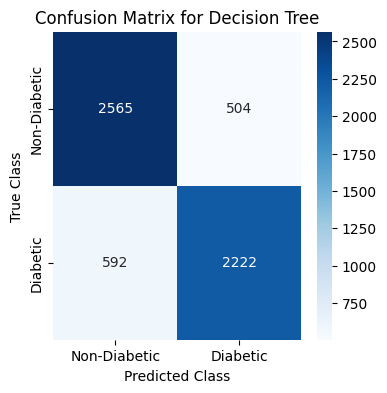

--------------------------------------------------------
Accuracy for Naive Bayes: 0.8042
              precision    recall  f1-score   support

           0       0.81      0.81      0.81      3069
           1       0.80      0.79      0.79      2814

    accuracy                           0.80      5883
   macro avg       0.80      0.80      0.80      5883
weighted avg       0.80      0.80      0.80      5883



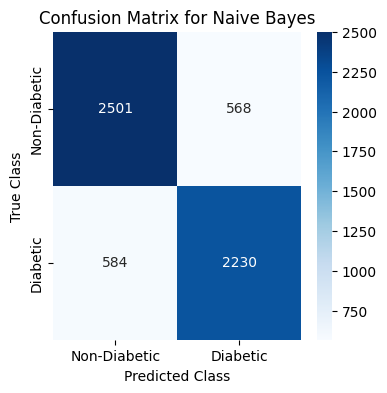

--------------------------------------------------------
Accuracy for Logistic Regression: 0.8144
              precision    recall  f1-score   support

           0       0.82      0.82      0.82      3069
           1       0.81      0.80      0.81      2814

    accuracy                           0.81      5883
   macro avg       0.81      0.81      0.81      5883
weighted avg       0.81      0.81      0.81      5883



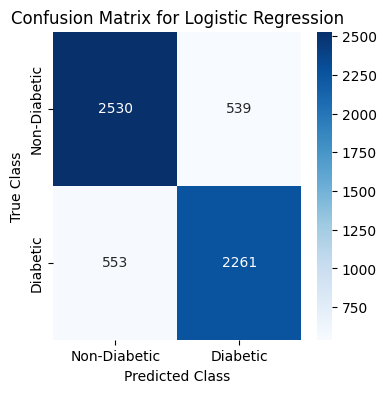

--------------------------------------------------------
Accuracy for KNN: 0.8246
              precision    recall  f1-score   support

           0       0.78      0.92      0.85      3069
           1       0.90      0.72      0.80      2814

    accuracy                           0.82      5883
   macro avg       0.84      0.82      0.82      5883
weighted avg       0.84      0.82      0.82      5883



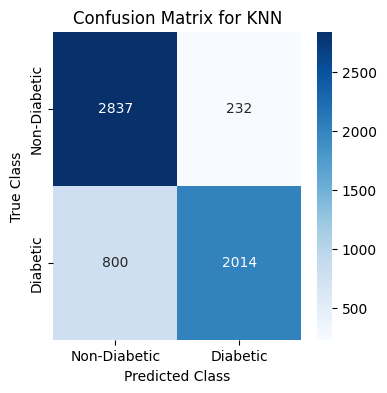

--------------------------------------------------------
Accuracy for Ensembled Voting: 0.8419
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      3069
           1       0.90      0.76      0.82      2814

    accuracy                           0.84      5883
   macro avg       0.85      0.84      0.84      5883
weighted avg       0.85      0.84      0.84      5883



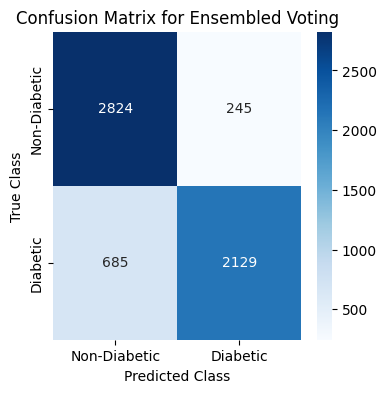

--------------------------------------------------------


In [2]:
for model_pred, model_name in zip(model_preds, model_names):
    conf_matrix = confusion_matrix(Y_valid, model_pred)
    accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

    print(f"Accuracy for {model_name}: {accuracy:.4f}")
    print(classification_report(Y_valid, model_pred))
    # Plotting Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(
        conf_matrix,
        annot=True,
        fmt=".0f",
        cmap="Blues",
        xticklabels=["Non-Diabetic", "Diabetic"],
        yticklabels=["Non-Diabetic", "Diabetic"],
    )
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

    print("--------------------------------------------------------")

##ensembling
ensemble_voting = pd.DataFrame(model_preds).mode().values[0]
conf_matrix = confusion_matrix(Y_valid, ensemble_voting)
accuracy = np.trace(conf_matrix) / float(np.sum(conf_matrix))

print(f"Accuracy for Ensembled Voting: {accuracy:.4f}")
print(classification_report(Y_valid, ensemble_voting))
# Plotting Confusion Matrix
plt.figure(figsize=(4, 4))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt=".0f",
    cmap="Blues",
    xticklabels=["Non-Diabetic", "Diabetic"],
    yticklabels=["Non-Diabetic", "Diabetic"],
)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title(f"Confusion Matrix for Ensembled Voting")
plt.show()

print("--------------------------------------------------------")

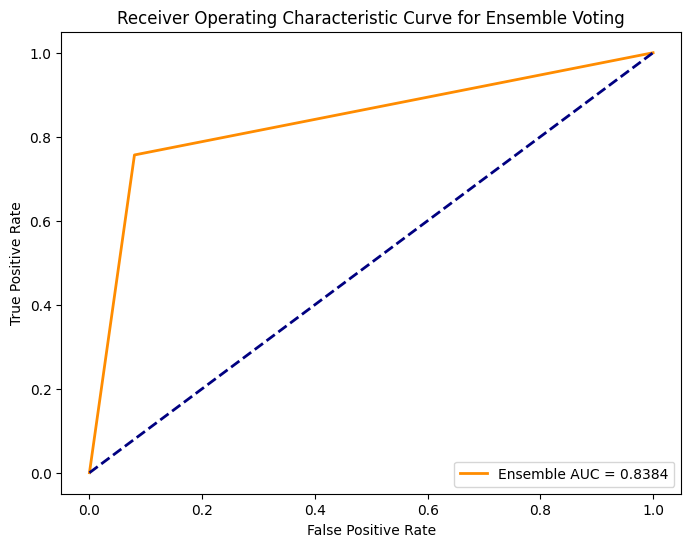

AUC for Ensemble Voting: 0.8384


In [3]:
from sklearn.metrics import roc_curve, auc
 
ensemble_voting = pd.DataFrame(model_preds).mode().values[0]
 
#Calculating ROC curve for ensemble
fpr, tpr, thresholds = roc_curve(Y_valid, ensemble_voting)
 
#Calculating AUC for ensemble
ensemble_auc = auc(fpr, tpr)
 
#Plotting.
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Ensemble AUC = {ensemble_auc:.4f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve for Ensemble Voting')
plt.legend(loc="lower right")
plt.show()
 
print(f"AUC for Ensemble Voting: {ensemble_auc:.4f}")

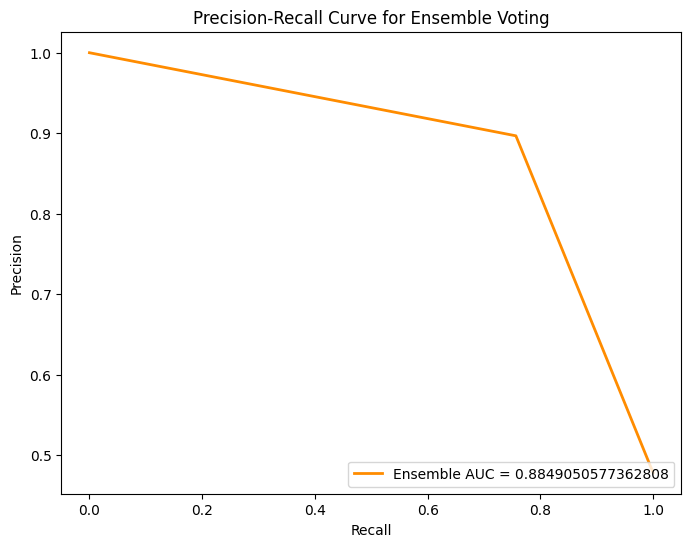

In [4]:
from sklearn.metrics import precision_recall_curve, auc
 
precision, recall, _ = precision_recall_curve(Y_valid, ensemble_voting)
 
ensemble_auc_pr = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='darkorange', lw=2, label=f'Ensemble AUC = {ensemble_auc_pr:}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Ensemble Voting')
plt.legend(loc="lower right")
plt.show()